In [122]:
pip install gpflow tensorflow~=2.10.0 tensorflow-probability~=0.18.0

In [123]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.dates as mdates
import numpy as np
import os
import gpflow
import warnings
warnings.filterwarnings('ignore')

In [244]:
df = pd.read_csv('PNJ.csv', index_col ="Date/Time")
df.head()

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,,
2/28/2018 9:15,PNJ,78.14,78.99,78.14,78.99,270,0
2/28/2018 9:16,PNJ,78.94,78.94,78.94,78.94,10,0
2/28/2018 9:19,PNJ,78.14,78.14,78.14,78.14,283,0
2/28/2018 9:20,PNJ,78.14,78.14,78.14,78.14,480,0
2/28/2018 9:21,PNJ,78.14,78.14,78.14,78.14,146,0


In [245]:
df = df.iloc[:, 4:5]
df = df.dropna()
df.index = pd.to_datetime(df.index)
df['Day'] = df.index.day
df['Year'], df['Month'] = df.index.year, df.index.month
df = df.resample('12H').mean().dropna()
df.head()

,Close,Day,Year,Month
Date/Time,,,,
2018-02-28 00:00:00,78.716989,28.0,2018.0,2.0
2018-03-01 00:00:00,78.770345,1.0,2018.0,3.0
2018-03-01 12:00:00,78.386462,1.0,2018.0,3.0
2018-03-02 00:00:00,77.176768,2.0,2018.0,3.0
2018-03-02 12:00:00,77.438769,2.0,2018.0,3.0


## Log-returns

In [246]:
df['log_returns'] = np.log(df.Close).diff()
df.dropna(inplace=True)

In [247]:
index = np.array([])
for year in df['Year'].unique():
    close = df.Close[df['Year'] == year]
    index = np.append(index, range(0, len(close)))
df['Index'] = index

In [248]:
start_train = '2017-12-25'
end_train = '2020-01-31'
df_train = df[(df.index >= start_train) & (df.index <= end_train)].iloc[:, :]
df_train.head()

,Close,Day,Year,Month,log_returns,Index
Date/Time,,,,,,
2018-03-01 00:00:00,78.770345,1.0,2018.0,3.0,0.000678,0.0
2018-03-01 12:00:00,78.386462,1.0,2018.0,3.0,-0.004885,1.0
2018-03-02 00:00:00,77.176768,2.0,2018.0,3.0,-0.015553,2.0
2018-03-02 12:00:00,77.438769,2.0,2018.0,3.0,0.003389,3.0
2018-03-05 00:00:00,78.138765,5.0,2018.0,3.0,0.008999,4.0


In [249]:
X_train = np.array(df_train[['Year', 'Month', 'Day', 'Index']])
y_train = df_train.iloc[:, 4].values
len(X_train)

959

In [250]:
start_predict = '2020-01-31'
end_predict = '2020-11-22'
df_predict = df[(df.index >= start_predict) & (df.index <= end_predict)]
df_predict.head()

,Close,Day,Year,Month,log_returns,Index
Date/Time,,,,,,
2020-01-31 00:00:00,86.524597,31.0,2020.0,1.0,-0.009710,32.0
2020-01-31 12:00:00,84.880353,31.0,2020.0,1.0,-0.019186,33.0
2020-02-03 00:00:00,79.876418,3.0,2020.0,2.0,-0.060762,34.0
2020-02-03 12:00:00,81.562500,3.0,2020.0,2.0,0.020889,35.0
2020-02-04 00:00:00,82.496283,4.0,2020.0,2.0,0.011384,36.0


In [251]:
X_predict = np.array(df_predict[['Year', 'Month', 'Day', 'Index']])
y_test = df_predict.iloc[:, 4].values
len(X_predict)

414

In [252]:
y_train.reshape(-1, 1).shape

(959, 1)

In [253]:
print(gpflow.kernels.ChangePoints)

<class 'gpflow.kernels.changepoints.ChangePoints'>


In [254]:
model = gpflow.models.GPR((X_train, y_train.reshape(-1, 1)),
                          kernel = gpflow.kernels.Matern32())

opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -2865.020671536563
        x: [ 1.033e+00 -9.973e+00 -9.157e+00]
      nit: 18
      jac: [ 4.890e-04  1.358e-03  1.020e-03]
     nfev: 28
     njev: 28
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [255]:
y_pred, y_var = model.predict_f(X_predict, full_cov = False)

In [256]:
y_lower = y_pred - 1.96 * np.sqrt(y_var)
y_upper = y_pred + 1.96 * np.sqrt(y_var)

### Visualization

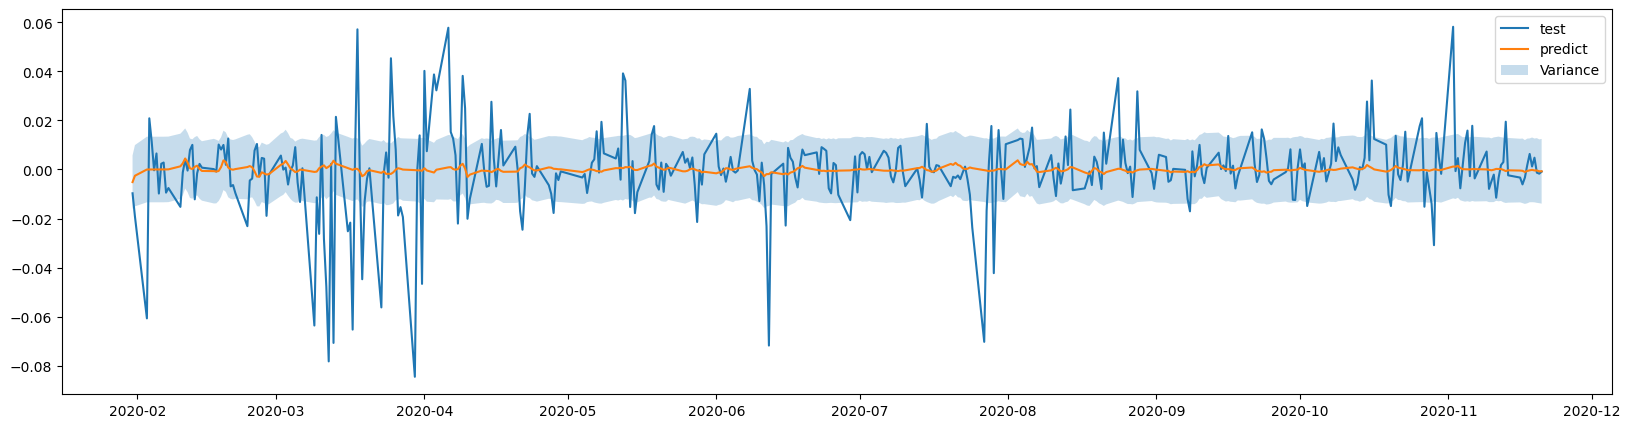

In [257]:
plt.figure(figsize=(20, 5))
plt.plot(df_predict.index, y_test, label = 'test')
plt.plot(df_predict.index, y_pred, label = 'predict')
plt.fill_between(df_predict.index, np.array(y_lower).squeeze(), np.array(y_upper).squeeze(), alpha = 0.25, label = 'Variance')
plt.legend()
plt.show()

## Volatility

In [258]:
df = pd.read_csv('PNJ.csv', index_col ="Date/Time")
df.head()

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,,
2/28/2018 9:15,PNJ,78.14,78.99,78.14,78.99,270,0
2/28/2018 9:16,PNJ,78.94,78.94,78.94,78.94,10,0
2/28/2018 9:19,PNJ,78.14,78.14,78.14,78.14,283,0
2/28/2018 9:20,PNJ,78.14,78.14,78.14,78.14,480,0
2/28/2018 9:21,PNJ,78.14,78.14,78.14,78.14,146,0


In [259]:
df = df.iloc[:, 4:5]
df = df.dropna()
df.index = pd.to_datetime(df.index)
df['Day'] = df.index.day
df['Year'], df['Month'] = df.index.year, df.index.month
df = df.resample('12H').mean().dropna()
df.head()

,Close,Day,Year,Month
Date/Time,,,,
2018-02-28 00:00:00,78.716989,28.0,2018.0,2.0
2018-03-01 00:00:00,78.770345,1.0,2018.0,3.0
2018-03-01 12:00:00,78.386462,1.0,2018.0,3.0
2018-03-02 00:00:00,77.176768,2.0,2018.0,3.0
2018-03-02 12:00:00,77.438769,2.0,2018.0,3.0


In [260]:
index = np.array([])
for year in df['Year'].unique():
    close = df.Close[df['Year'] == year]
    index = np.append(index, range(0, len(close)))
df['Index'] = index
df['vol_5'] = df['Close'].rolling(5).std()
df.dropna(inplace = True)
df

,Close,Day,Year,Month,Index,vol_5
Date/Time,,,,,,
2018-03-02 12:00:00,77.438769,2.0,2018.0,3.0,4.0,0.741899
2018-03-05 00:00:00,78.138765,5.0,2018.0,3.0,5.0,0.662033
2018-03-05 12:00:00,79.431486,5.0,2018.0,3.0,6.0,0.886702
2018-03-06 00:00:00,79.622364,6.0,2018.0,3.0,7.0,1.122417
2018-03-06 12:00:00,80.653243,6.0,2018.0,3.0,8.0,1.271780
...,...,...,...,...,...,...
2020-12-18 12:00:00,76.673973,18.0,2020.0,12.0,485.0,0.395314
2020-12-21 00:00:00,77.066393,21.0,2020.0,12.0,486.0,0.298120
2020-12-21 12:00:00,76.920000,21.0,2020.0,12.0,487.0,0.312119


In [261]:
start_train = '2018-12-25'
end_train = '2020-01-31'
df_train = df[(df.index >= start_train) & (df.index <= end_train)].iloc[:, :]
df_train.head()

,Close,Day,Year,Month,Index,vol_5
Date/Time,,,,,,
2018-12-25 00:00:00,67.404286,25.0,2018.0,12.0,419.0,0.633538
2018-12-25 12:00:00,67.597778,25.0,2018.0,12.0,420.0,0.645839
2018-12-26 00:00:00,67.736061,26.0,2018.0,12.0,421.0,0.662043
2018-12-26 12:00:00,67.377500,26.0,2018.0,12.0,422.0,0.530529
2018-12-27 00:00:00,68.404819,27.0,2018.0,12.0,423.0,0.418297


In [262]:
X_train = np.array(df_train[['Year', 'Month', 'Day', 'Index']])
y_train = df_train.iloc[:, 5].values
len(X_train)

541

In [263]:
start_predict = '2020-01-31'
end_predict = '2020-11-22'
df_predict = df[(df.index >= start_predict) & (df.index <= end_predict)]
df_predict.head()

,Close,Day,Year,Month,Index,vol_5
Date/Time,,,,,,
2020-01-31 00:00:00,86.524597,31.0,2020.0,1.0,32.0,1.746603
2020-01-31 12:00:00,84.880353,31.0,2020.0,1.0,33.0,2.260145
2020-02-03 00:00:00,79.876418,3.0,2020.0,2.0,34.0,3.538969
2020-02-03 12:00:00,81.562500,3.0,2020.0,2.0,35.0,3.218464
2020-02-04 00:00:00,82.496283,4.0,2020.0,2.0,36.0,2.646331


In [264]:
X_predict = np.array(df_predict[['Year', 'Month', 'Day', 'Index']])
y_test = df_predict.iloc[:, 5].values
len(X_predict)

414

In [265]:
model = gpflow.models.GPR((X_train, y_train.reshape(-1, 1)),
                          kernel = gpflow.kernels.Matern32())

opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -18.493004412246933
        x: [ 4.328e+00 -7.862e-01 -8.599e+00]
      nit: 22
      jac: [-4.869e-04  1.610e-03  1.485e-05]
     nfev: 41
     njev: 41
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [266]:
y_pred, y_var = model.predict_f(X_predict, full_cov = False)

In [267]:
y_lower = y_pred - 1.96 * np.sqrt(y_var)
y_upper = y_pred + 1.96 * np.sqrt(y_var)

### Visualization

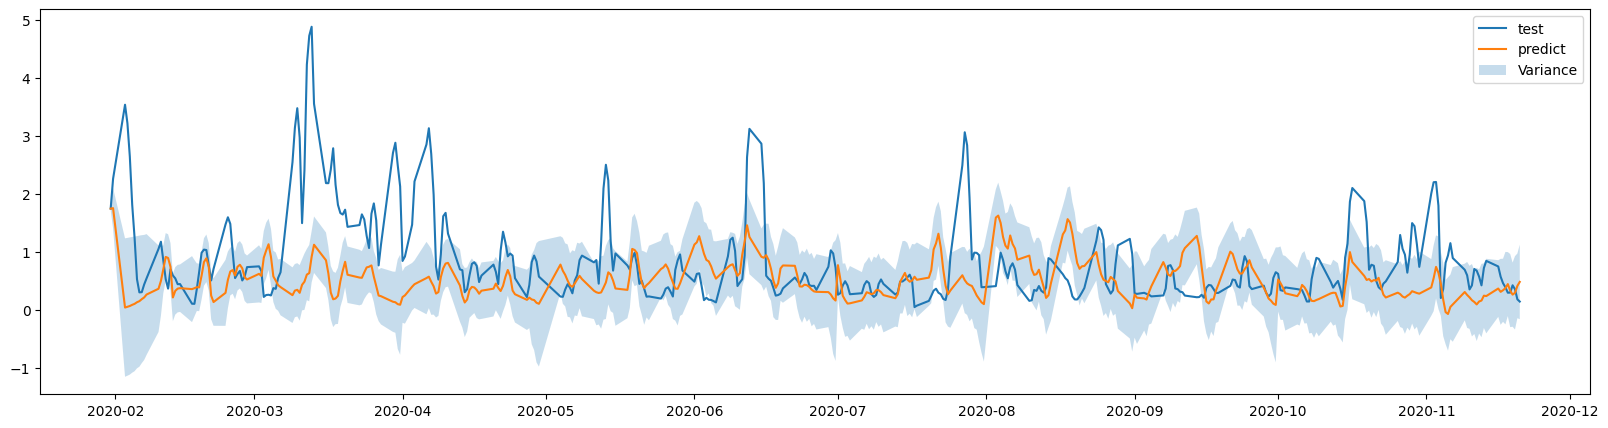

In [268]:
plt.figure(figsize=(20, 5))
plt.plot(df_predict.index, y_test, label = 'test')
plt.plot(df_predict.index, y_pred, label = 'predict')
plt.fill_between(df_predict.index, np.array(y_lower).squeeze(), np.array(y_upper).squeeze(), alpha = 0.25, label = 'Variance')
plt.legend()
plt.show()